# training demo for pytorch models

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR
import seaborn as sns


In [3]:
# load training data
base_path = "/Users/videllesita/Desktop/OSUCourses/Academic Years/Senior Year/ece5307course/final-project-group-06/"
Xtr_loadpath = base_path + 'Xtr.csv'
Xka_loadpath = base_path + 'Xka.csv'
ytr_loadpath = base_path + 'ytr.csv'

# load training data
Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
Xka = np.loadtxt(Xka_loadpath, delimiter=",")
ytr = np.loadtxt(ytr_loadpath, delimiter=",")


In [ ]:
# View number of samples per class
unique_classes, class_counts = np.unique(ytr, return_counts=True)

for label, count in zip(unique_classes, class_counts):
    print(f"Class {label}: {count} samples")


Class 0.0: 4127 samples
Class 1.0: 99 samples
Class 2.0: 339 samples
Class 3.0: 1055 samples
Class 4.0: 1889 samples
Class 5.0: 430 samples
Class 6.0: 500 samples
Class 7.0: 801 samples
Class 8.0: 503 samples
Class 9.0: 257 samples


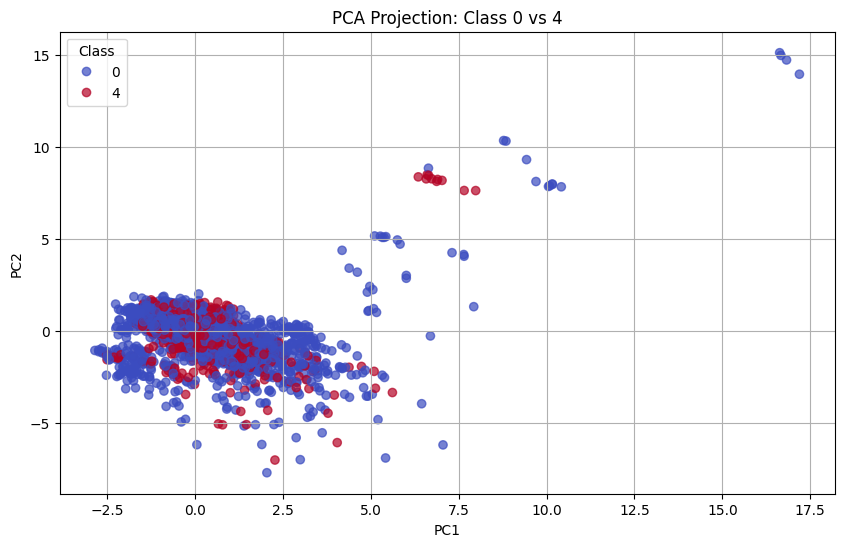

PCA with 7 components explains 90.48% of variance


In [ ]:
# Standardize the data
Xtr_mean = Xtr.mean(axis=0)
Xtr_std = Xtr.std(axis=0)
Xtr_standardized = (Xtr - Xtr_mean) / Xtr_std
Xka_standardized = (Xka - Xtr_mean) / Xtr_std

# Filter for class 0 and 4
mask = (ytr == 0) | (ytr == 4)
X_0_4 = Xtr_standardized[mask]
y_0_4 = ytr[mask]

# Run PCA
pca = PCA(n_components=2)
X_proj = pca.fit_transform(X_0_4)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y_0_4, cmap='coolwarm', alpha=0.7)
plt.title("PCA Projection: Class 0 vs 4")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Class")
plt.grid(True)
plt.show()


# Apply PCA
n_components = 7
pca = PCA(n_components=n_components)
Xtr_standardized = pca.fit_transform(Xtr_standardized)
Xka_standardized = pca.transform(Xka_standardized)

# Print explained variance ratio
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"PCA with {n_components} components explains {explained_variance:.2%} of variance")

# save the standardized training data
Xtr_savepath = base_path + 'Xtr_neuralnet.csv'
Xka_savepath = base_path + 'Xka_neuralnet.csv'
yka_hat_savepath = base_path + 'yka_hat_neuralnet.csv'

np.savetxt(Xtr_savepath, Xtr_standardized, delimiter=",")
np.savetxt(Xka_savepath, Xka_standardized, delimiter=",")
np.savetxt(base_path + 'ytr_neuralnet.csv', ytr, delimiter=",")

In [ ]:
# Create neural network model
d_in = Xtr_standardized.shape[1]  
d_out = 10 

class MLPNet(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(MLPNet, self).__init__()

        self.layers = nn.Sequential(
            # Layer 1: 3072
            nn.Linear(d_in, 3072),
            nn.BatchNorm1d(3072),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            # Layer 2: 2048
            nn.Linear(3072, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            # Layer 3: 2048
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            # Layer 4–6: 1024
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            # Layer 7: 896
            nn.Linear(1024, 896),
            nn.BatchNorm1d(896),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            # Layer 8: 768
            nn.Linear(896, 768),
            nn.BatchNorm1d(768),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            # Layer 9: 640
            nn.Linear(768, 640),
            nn.BatchNorm1d(640),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            # Output layer
            nn.Linear(640, d_out)
        )

    def forward(self, x):
        return self.layers(x)



Training fold 1/5
Fold 1, Epoch 1/100, Loss: 1.6193, Val Acc: 0.3823, Best: 0.3823
Fold 1, Epoch 2/100, Loss: 1.1133, Val Acc: 0.5380, Best: 0.5380
Fold 1, Epoch 3/100, Loss: 0.9783, Val Acc: 0.6336, Best: 0.6336
Fold 1, Epoch 4/100, Loss: 0.8604, Val Acc: 0.6854, Best: 0.6854
Fold 1, Epoch 5/100, Loss: 0.7536, Val Acc: 0.7038, Best: 0.7038
Fold 1, Epoch 6/100, Loss: 0.7035, Val Acc: 0.7136, Best: 0.7136
Fold 1, Epoch 7/100, Loss: 0.6814, Val Acc: 0.7196, Best: 0.7196
Fold 1, Epoch 8/100, Loss: 0.6605, Val Acc: 0.7506, Best: 0.7506
Fold 1, Epoch 9/100, Loss: 0.5946, Val Acc: 0.7354, Best: 0.7506
Fold 1, Epoch 10/100, Loss: 0.5934, Val Acc: 0.7444, Best: 0.7506
Fold 1, Epoch 11/100, Loss: 0.5789, Val Acc: 0.7061, Best: 0.7506
Fold 1, Epoch 12/100, Loss: 0.5665, Val Acc: 0.7555, Best: 0.7555
Fold 1, Epoch 13/100, Loss: 0.5386, Val Acc: 0.7792, Best: 0.7792
Fold 1, Epoch 14/100, Loss: 0.5461, Val Acc: 0.7678, Best: 0.7792
Fold 1, Epoch 15/100, Loss: 0.4855, Val Acc: 0.7823, Best: 0.7823


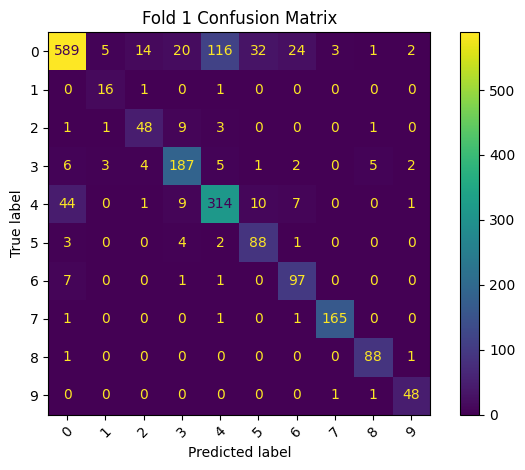

Fold 1 final validation balanced accuracy: 0.8798


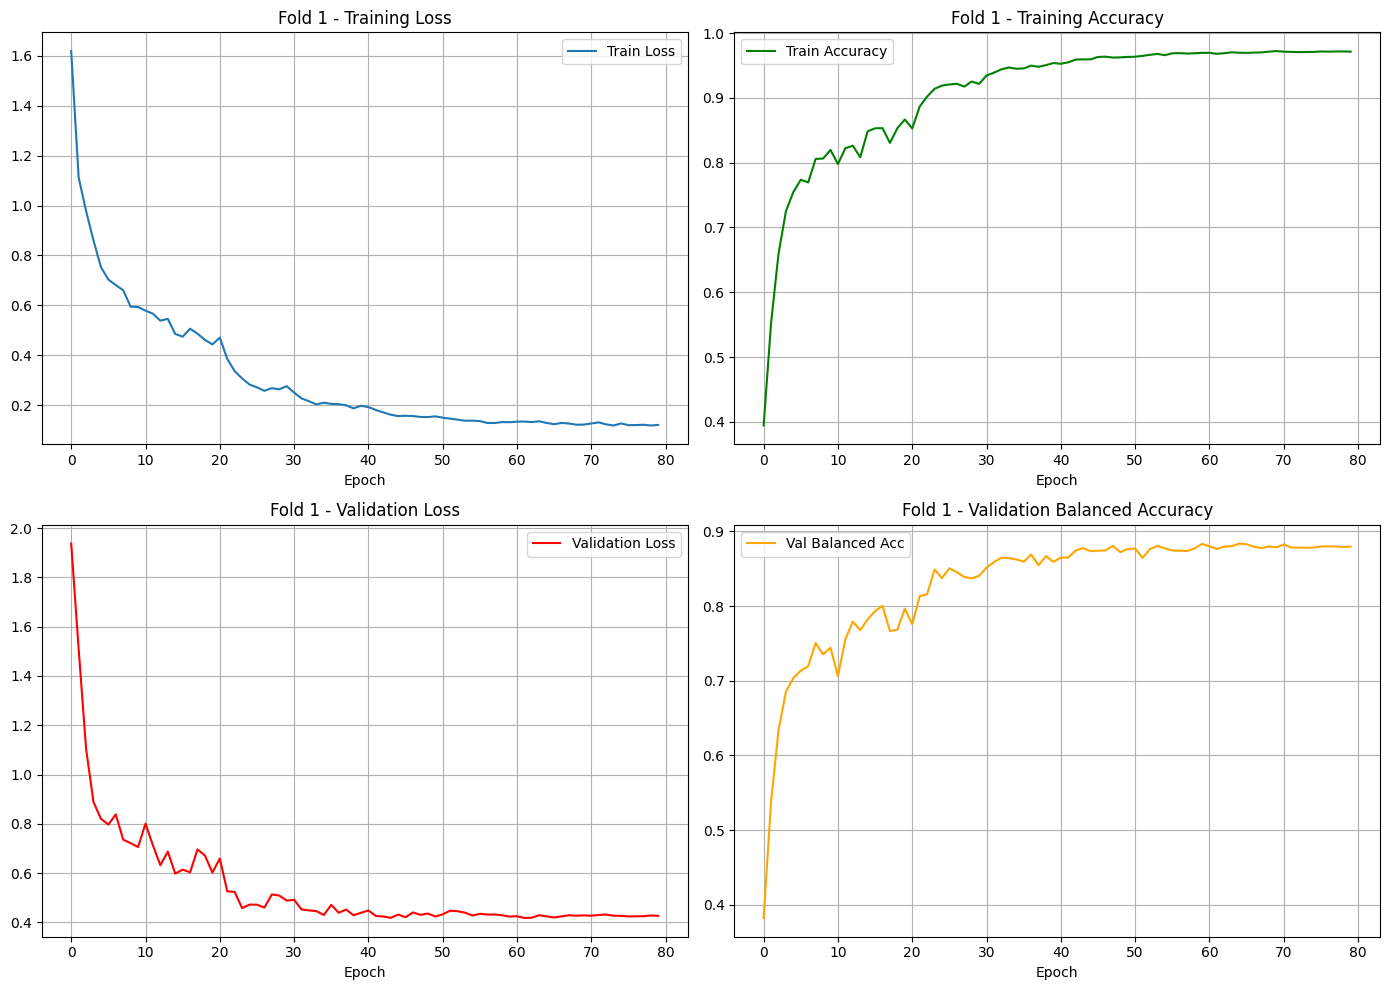


Training fold 2/5
Fold 2, Epoch 1/100, Loss: 1.7024, Val Acc: 0.4342, Best: 0.4342
Fold 2, Epoch 2/100, Loss: 1.1217, Val Acc: 0.5846, Best: 0.5846
Fold 2, Epoch 3/100, Loss: 1.0047, Val Acc: 0.6300, Best: 0.6300
Fold 2, Epoch 4/100, Loss: 0.8887, Val Acc: 0.7266, Best: 0.7266
Fold 2, Epoch 5/100, Loss: 0.7686, Val Acc: 0.7110, Best: 0.7266
Fold 2, Epoch 6/100, Loss: 0.7222, Val Acc: 0.7352, Best: 0.7352
Fold 2, Epoch 7/100, Loss: 0.6893, Val Acc: 0.7532, Best: 0.7532
Fold 2, Epoch 8/100, Loss: 0.6496, Val Acc: 0.7689, Best: 0.7689
Fold 2, Epoch 9/100, Loss: 0.6038, Val Acc: 0.7700, Best: 0.7700
Fold 2, Epoch 10/100, Loss: 0.6023, Val Acc: 0.7660, Best: 0.7700
Fold 2, Epoch 11/100, Loss: 0.6082, Val Acc: 0.7581, Best: 0.7700
Fold 2, Epoch 12/100, Loss: 0.5864, Val Acc: 0.7886, Best: 0.7886
Fold 2, Epoch 13/100, Loss: 0.5299, Val Acc: 0.7944, Best: 0.7944
Fold 2, Epoch 14/100, Loss: 0.4847, Val Acc: 0.8069, Best: 0.8069
Fold 2, Epoch 15/100, Loss: 0.4687, Val Acc: 0.7898, Best: 0.8069


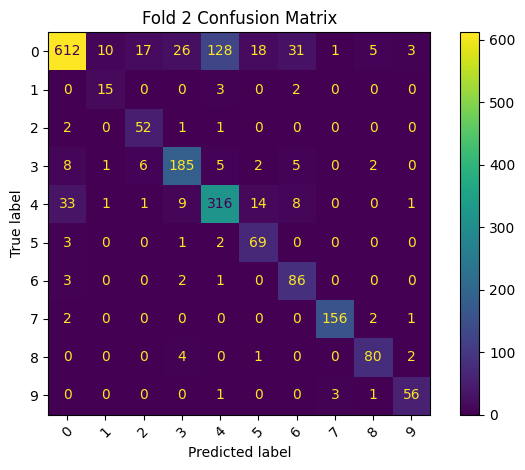

Fold 2 final validation balanced accuracy: 0.8749


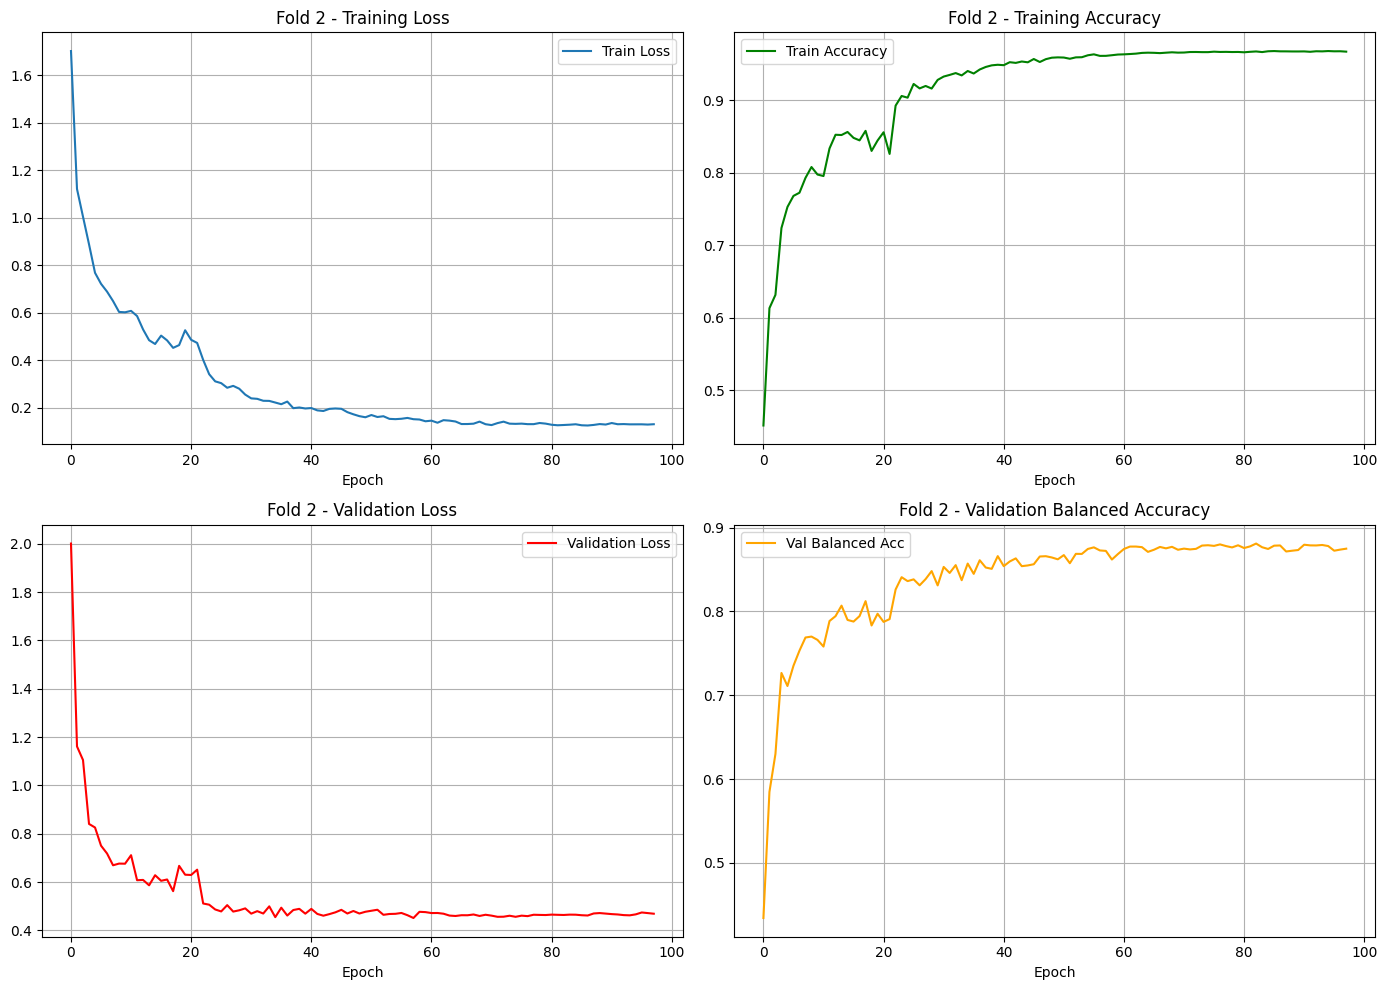


Training fold 3/5
Fold 3, Epoch 1/100, Loss: 1.6399, Val Acc: 0.3785, Best: 0.3785
Fold 3, Epoch 2/100, Loss: 1.1438, Val Acc: 0.5743, Best: 0.5743
Fold 3, Epoch 3/100, Loss: 0.9558, Val Acc: 0.6201, Best: 0.6201
Fold 3, Epoch 4/100, Loss: 0.8110, Val Acc: 0.6591, Best: 0.6591
Fold 3, Epoch 5/100, Loss: 0.8289, Val Acc: 0.6766, Best: 0.6766
Fold 3, Epoch 6/100, Loss: 0.7573, Val Acc: 0.7007, Best: 0.7007
Fold 3, Epoch 7/100, Loss: 0.6912, Val Acc: 0.7279, Best: 0.7279
Fold 3, Epoch 8/100, Loss: 0.6647, Val Acc: 0.7262, Best: 0.7279
Fold 3, Epoch 9/100, Loss: 0.6620, Val Acc: 0.7405, Best: 0.7405
Fold 3, Epoch 10/100, Loss: 0.5722, Val Acc: 0.7552, Best: 0.7552
Fold 3, Epoch 11/100, Loss: 0.5289, Val Acc: 0.7849, Best: 0.7849
Fold 3, Epoch 12/100, Loss: 0.5186, Val Acc: 0.7628, Best: 0.7849
Fold 3, Epoch 13/100, Loss: 0.5082, Val Acc: 0.7525, Best: 0.7849
Fold 3, Epoch 14/100, Loss: 0.5300, Val Acc: 0.7656, Best: 0.7849
Epoch 00015: reducing learning rate of group 0 to 3.7500e-04.
Fold

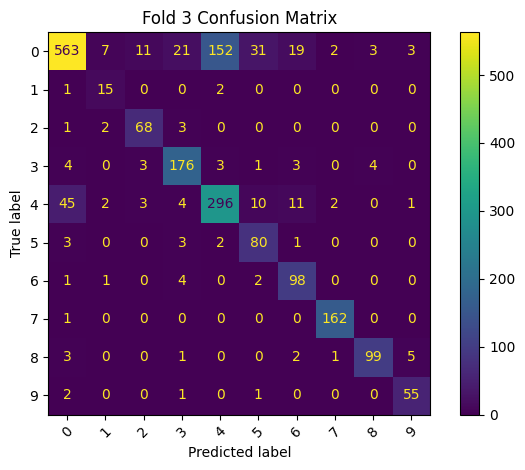

Fold 3 final validation balanced accuracy: 0.8786


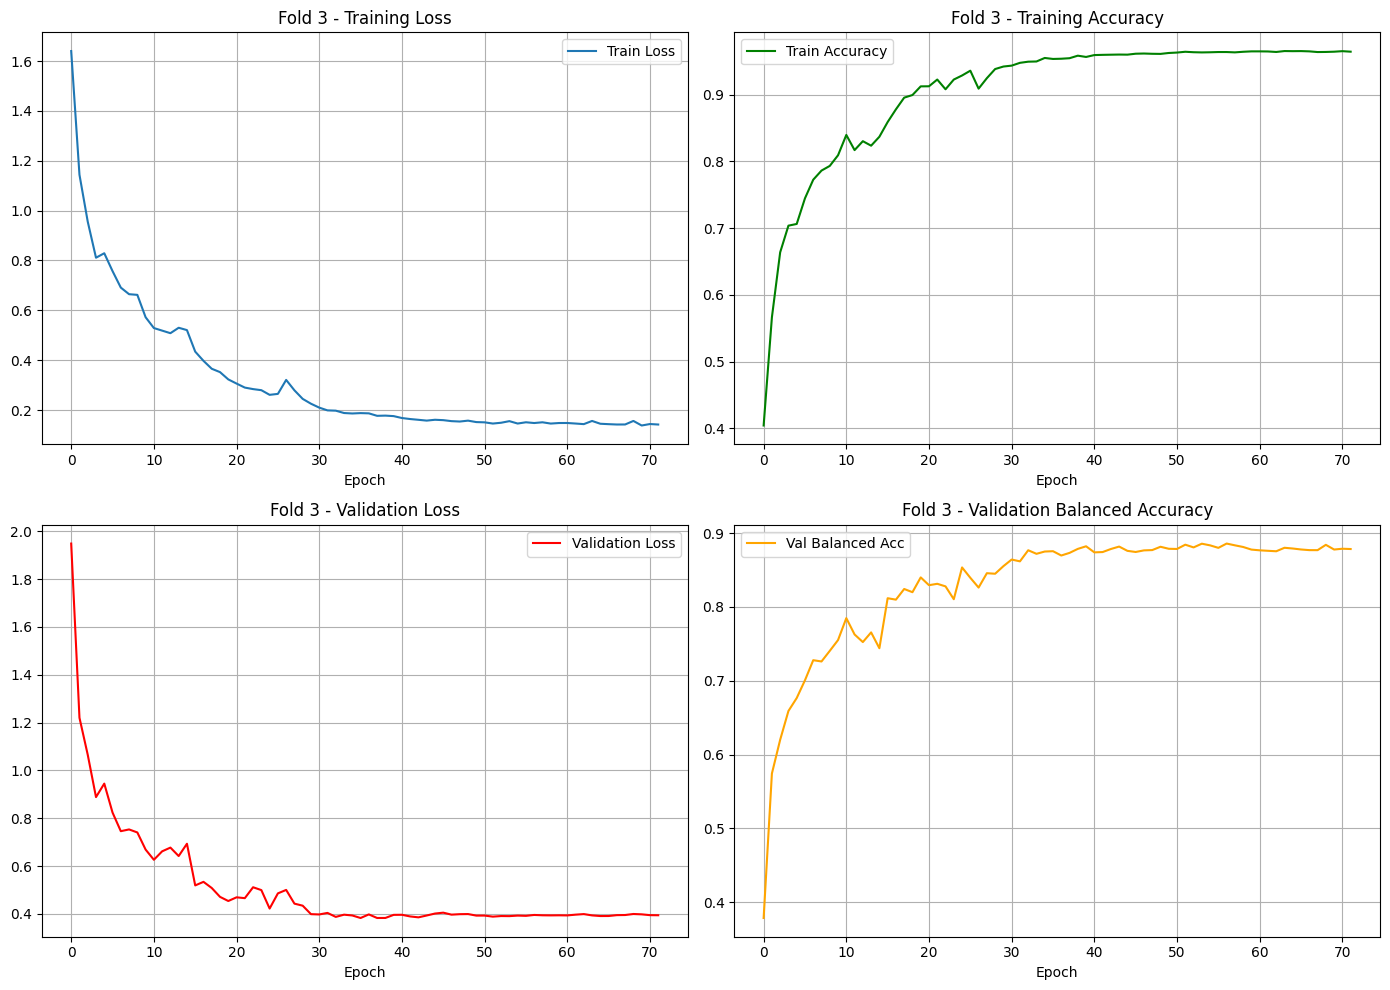


Training fold 4/5
Fold 4, Epoch 1/100, Loss: 1.7123, Val Acc: 0.4391, Best: 0.4391
Fold 4, Epoch 2/100, Loss: 1.1220, Val Acc: 0.5757, Best: 0.5757
Fold 4, Epoch 3/100, Loss: 0.9326, Val Acc: 0.6344, Best: 0.6344
Fold 4, Epoch 4/100, Loss: 0.8541, Val Acc: 0.6771, Best: 0.6771
Fold 4, Epoch 5/100, Loss: 0.8028, Val Acc: 0.6831, Best: 0.6831
Fold 4, Epoch 6/100, Loss: 0.7799, Val Acc: 0.6959, Best: 0.6959
Fold 4, Epoch 7/100, Loss: 0.6782, Val Acc: 0.7239, Best: 0.7239
Fold 4, Epoch 8/100, Loss: 0.6488, Val Acc: 0.7588, Best: 0.7588
Fold 4, Epoch 9/100, Loss: 0.6152, Val Acc: 0.7172, Best: 0.7588
Fold 4, Epoch 10/100, Loss: 0.6222, Val Acc: 0.7430, Best: 0.7588
Fold 4, Epoch 11/100, Loss: 0.5601, Val Acc: 0.7424, Best: 0.7588
Epoch 00012: reducing learning rate of group 0 to 3.7500e-04.
Fold 4, Epoch 12/100, Loss: 0.5487, Val Acc: 0.7545, Best: 0.7588
Fold 4, Epoch 13/100, Loss: 0.4858, Val Acc: 0.8012, Best: 0.8012
Fold 4, Epoch 14/100, Loss: 0.4189, Val Acc: 0.7919, Best: 0.8012
Fold

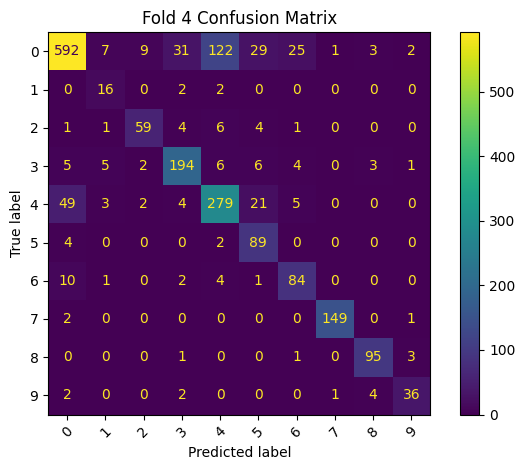

Fold 4 final validation balanced accuracy: 0.8415


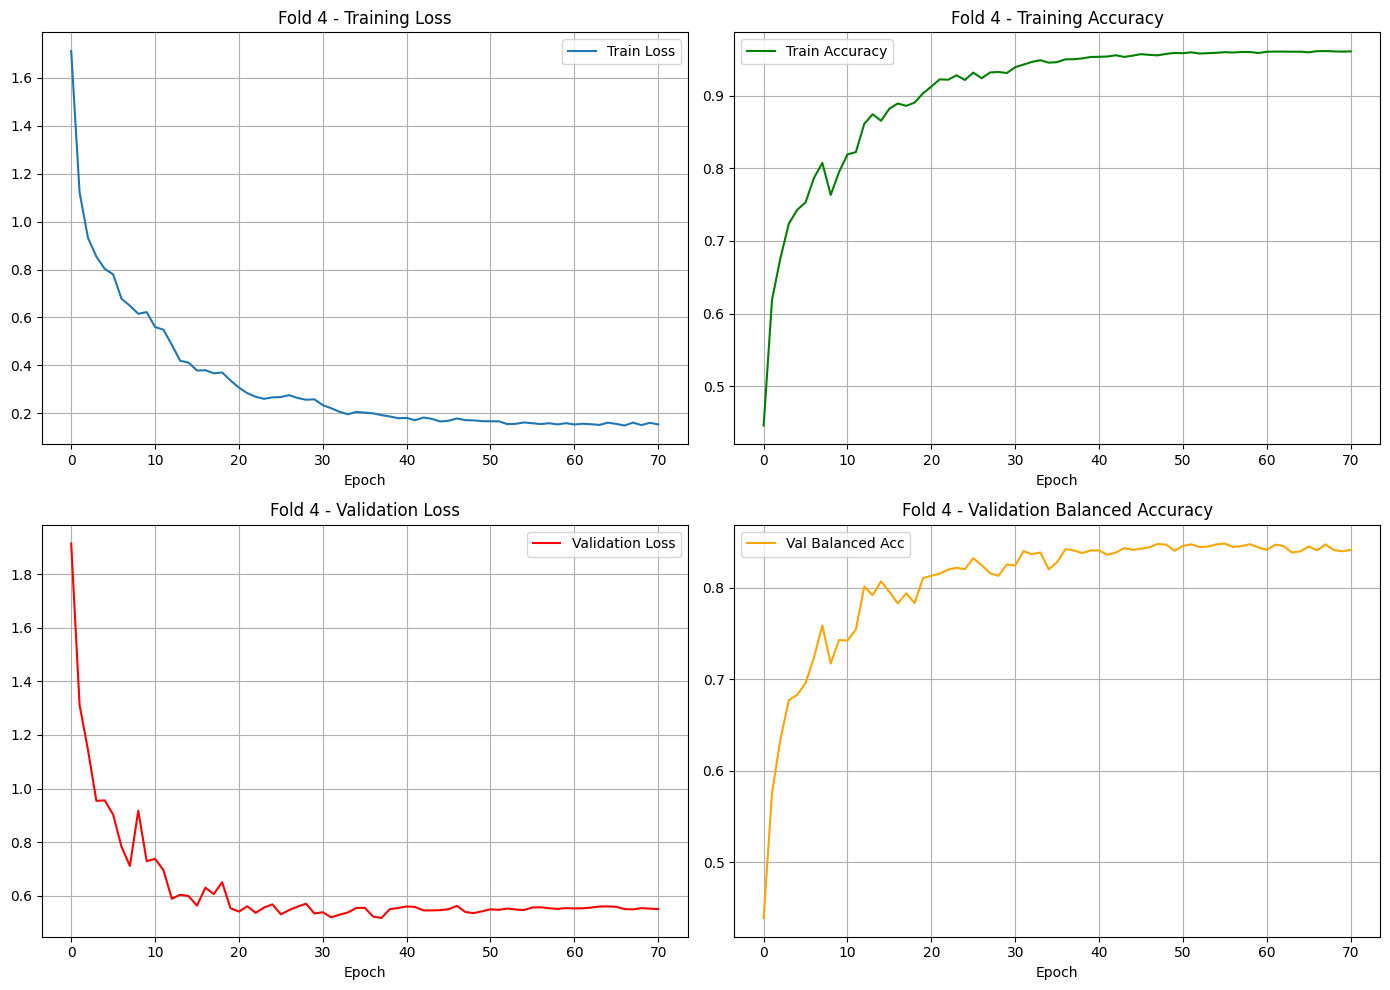


Training fold 5/5
Fold 5, Epoch 1/100, Loss: 1.6420, Val Acc: 0.4183, Best: 0.4183
Fold 5, Epoch 2/100, Loss: 1.1499, Val Acc: 0.5185, Best: 0.5185
Fold 5, Epoch 3/100, Loss: 0.9765, Val Acc: 0.6466, Best: 0.6466
Fold 5, Epoch 4/100, Loss: 0.8756, Val Acc: 0.6728, Best: 0.6728
Fold 5, Epoch 5/100, Loss: 0.7943, Val Acc: 0.6808, Best: 0.6808
Fold 5, Epoch 6/100, Loss: 0.7285, Val Acc: 0.7055, Best: 0.7055
Fold 5, Epoch 7/100, Loss: 0.6686, Val Acc: 0.7324, Best: 0.7324
Fold 5, Epoch 8/100, Loss: 0.6529, Val Acc: 0.7455, Best: 0.7455
Fold 5, Epoch 9/100, Loss: 0.6378, Val Acc: 0.7448, Best: 0.7455
Fold 5, Epoch 10/100, Loss: 0.5729, Val Acc: 0.7554, Best: 0.7554
Fold 5, Epoch 11/100, Loss: 0.5512, Val Acc: 0.7808, Best: 0.7808
Fold 5, Epoch 12/100, Loss: 0.5539, Val Acc: 0.7800, Best: 0.7808
Fold 5, Epoch 13/100, Loss: 0.5096, Val Acc: 0.7772, Best: 0.7808
Fold 5, Epoch 14/100, Loss: 0.4818, Val Acc: 0.7490, Best: 0.7808
Fold 5, Epoch 15/100, Loss: 0.4675, Val Acc: 0.7861, Best: 0.7861


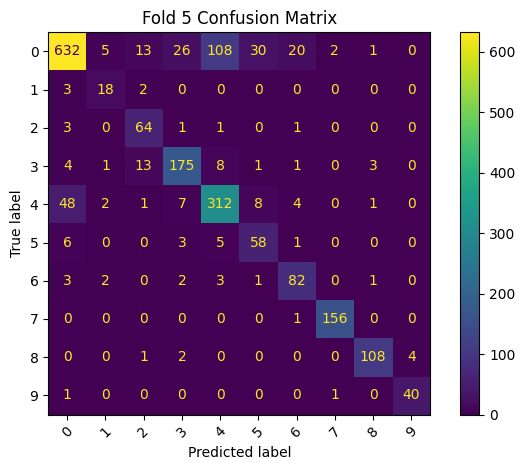

Fold 5 final validation balanced accuracy: 0.8668


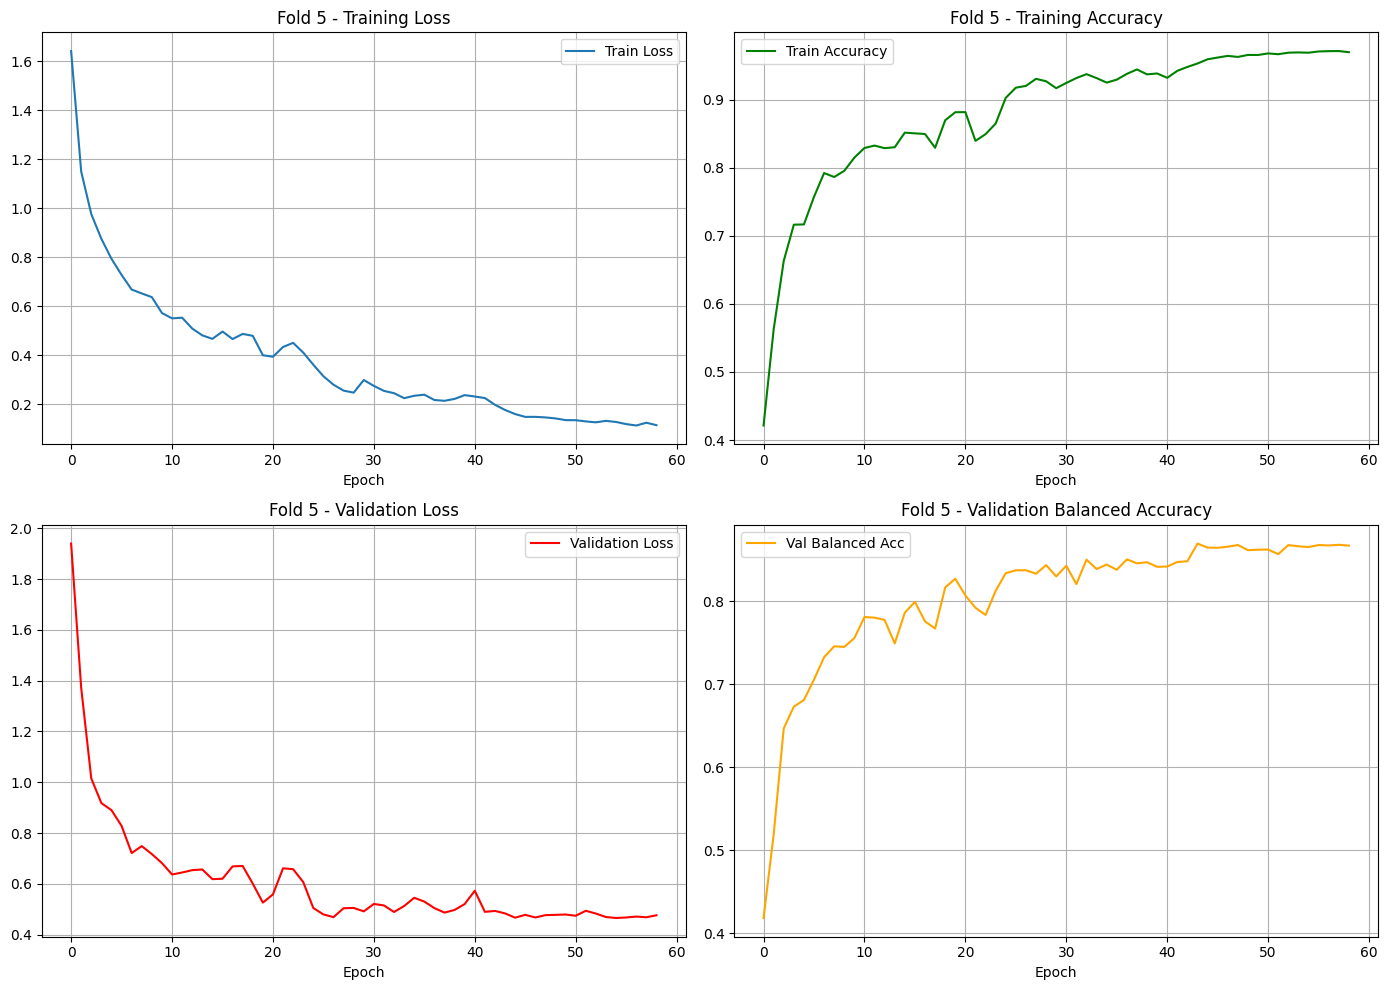

In [ ]:
# K-fold cross validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_val_scores = []
best_fold_model = None
best_fold_score = 0

for fold, (train_idx, val_idx) in enumerate(kf.split(Xtr_standardized)):
    print(f"\nTraining fold {fold+1}/{n_folds}")
    
    # Split data for this fold
    X_train, X_val = Xtr_standardized[train_idx], Xtr_standardized[val_idx]
    y_train, y_val = ytr[train_idx], ytr[val_idx]
    
    # Calculate class weights to handle imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
    #class_weights_tensor[4] = class_weights_tensor[4] * 1.5
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    
    # Batch Processing
    batch_size = 768
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # model drop of fold
    model = MLPNet(dropout_rate=0.05)
    
    # loss function, optimizer, and learning rate scheduler
    loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=7.5e-4, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    
    # Training setup
    epochs = 100
    patience = 15  
    counter = 0
    train_losses = []
    val_accuracies = []
    train_accuracies = []
    val_losses = []

    best_val_acc = 0.0
    best_model_state = None
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        # Train on batches
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Record average loss
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Compute training accuracy
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_tensor).argmax(dim=1).numpy()
            train_true = y_train_tensor.numpy()
            train_acc = balanced_accuracy_score(train_true, train_pred)
            train_accuracies.append(train_acc)  
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = loss_fn(val_outputs, y_val_tensor).item()
            val_pred = val_outputs.argmax(dim=1).numpy()
            val_acc = balanced_accuracy_score(y_val, val_pred)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()
                counter = 0
            else:
                counter += 1

            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        # Update learning rate scheduler
        scheduler.step(val_acc)
        
        # Print progress
        print(f"Fold {fold+1}, Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}, Best: {best_val_acc:.4f}")
    
    # Load best model for fold
    model.load_state_dict(best_model_state)
    
    # Final evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor).argmax(dim=1).numpy()
        final_val_acc = balanced_accuracy_score(y_val, val_pred)
    
    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    conf_mat = confusion_matrix(y_val, val_pred)
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot(xticks_rotation=45)
    plt.title(f"Fold {fold+1} Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"{base_path}fold_{fold+1}_confusion_matrix.png")
    plt.show()
    plt.close()

    print(f"Fold {fold+1} final validation balanced accuracy: {final_val_acc:.4f}")
    fold_val_scores.append(final_val_acc)
    

    # Keep track of best fold model
    if final_val_acc > best_fold_score:
        best_fold_score = final_val_acc
        best_fold_model = model.state_dict().copy()
    
    # Plot learning curves for this fold
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.title(f"Fold {fold+1} - Training Loss")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy", color='green')
    plt.title(f"Fold {fold+1} - Training Accuracy")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(val_losses, label="Validation Loss", color='red')
    plt.title(f"Fold {fold+1} - Validation Loss")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(val_accuracies, label="Val Balanced Acc", color='orange')
    plt.title(f"Fold {fold+1} - Validation Balanced Accuracy")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{base_path}fold_{fold+1}_learning_curve.png")
    plt.show()
    plt.close()

In [ ]:
# Print average validation score across all folds
avg_val_score = np.mean(fold_val_scores)
print(f"\nAverage validation balanced accuracy across {n_folds} folds: {avg_val_score:.4f}")
print(f"Individual fold scores: {fold_val_scores}")

# Print final accuracy summary
print("\nFinal validation scores:")
for i, score in enumerate(fold_val_scores):
    print(f"Fold {i+1}: {score:.4f}")
print(f"Average: {np.mean(fold_val_scores):.4f}")
print(f"Best: {np.max(fold_val_scores):.4f}")

# Create final model with best fold parameters
final_model = MLPNet()
final_model.load_state_dict(best_fold_model)
final_model.eval()

# Evaluate final model on full training data
with torch.no_grad():
    Xtr_tensor = torch.tensor(Xtr_standardized, dtype=torch.float32)
    train_pred = final_model(Xtr_tensor).argmax(dim=1).numpy()
    train_acc = balanced_accuracy_score(ytr, train_pred)
    print(f'Final model training balanced-accuracy: {train_acc:.4f}')

    


Average validation balanced accuracy across 5 folds: 0.8683
Individual fold scores: [0.8797775984230766, 0.8748576345421354, 0.8785627369837995, 0.8415024448945616, 0.8668110975158909]

Final validation scores:
Fold 1: 0.8798
Fold 2: 0.8749
Fold 3: 0.8786
Fold 4: 0.8415
Fold 5: 0.8668
Average: 0.8683
Best: 0.8798
Final model training balanced-accuracy: 0.9532


In [ ]:
# Save the best model
model_savepath = base_path + 'model_neuralnet.pth'
x = torch.randn(1, d_in)
with torch.no_grad():
    traced_cell = torch.jit.trace(final_model, x)
torch.jit.save(traced_cell, model_savepath)

In [12]:
# Generate Kaggle predictions
with torch.no_grad():
    Xka_tensor = torch.tensor(Xka_standardized, dtype=torch.float32)
    kaggle_pred = final_model(Xka_tensor).argmax(dim=1).numpy()
    np.savetxt(yka_hat_savepath, kaggle_pred, delimiter=",")

In [13]:
# Generate kaggle submission file using the validation script
import subprocess
subprocess.run(["python", base_path + "kaggle_csv.py", model_savepath, 
                "--Xka_path", Xka_savepath, 
                "--Xtr_path", Xtr_savepath, 
                "--yka_hat_path", yka_hat_savepath])

print(f"Finished! Model saved to {model_savepath}")
print(f"Kaggle predictions saved to {yka_hat_savepath}")

training balanced-accuracy =  0.9531946224731447
kaggle label predictions saved in /Users/videllesita/Desktop/OSUCourses/Academic Years/Senior Year/ece5307course/final-project-group-06/yka_hat_neuralnet.csv
Finished! Model saved to /Users/videllesita/Desktop/OSUCourses/Academic Years/Senior Year/ece5307course/final-project-group-06/model_neuralnet.pth
Kaggle predictions saved to /Users/videllesita/Desktop/OSUCourses/Academic Years/Senior Year/ece5307course/final-project-group-06/yka_hat_neuralnet.csv
